In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%matplotlib inline

from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.ndimage import distance_transform_edt

import emc2d

np.random.seed(42)

## SImulated data

In [3]:
intensity = np.load("./data/4BED_t40_d5000.npy")

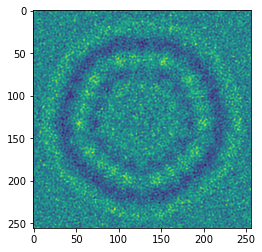

In [4]:
plt.imshow(intensity)

In [34]:
drift_radius = (15, 15)
mean_count= 0.05
motion_sigma = 1.
num_frames = 500
frame_size = (128, 128)
model_size = (frame_size[0] + 2*drift_radius[0], frame_size[1] + 2*drift_radius[1])
model = emc2d.sim.build_model(intensity, model_size=model_size, mean_count=mean_count)
n_drifts = (2*drift_radius[0] + 1) * (2*drift_radius[1] + 1)

frames, traj = emc2d.sim.generate_frames(
    intensity, 
    frame_size, 
    drift_radius=drift_radius, 
    num_frames=num_frames, 
    mean_count=mean_count, 
    motion_sigma=motion_sigma)

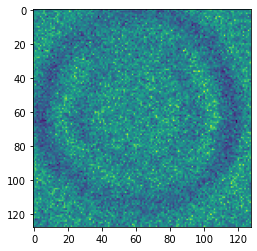

In [35]:
plt.imshow(frames[:].sum(0))

## Initialize EMC

In [36]:
emc = emc2d.core.EMC(
    frames=frames, 
    frame_size=(128, 128), 
    drift_radius=drift_radius, 
    init_model='random')

nnz / data_size = 4.74%, using dense data format
nnz / data_size = 4.74%, using dense data format


Text(0.5, 1.0, 'initial model')

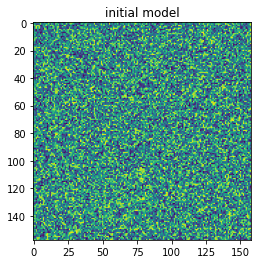

In [37]:
plt.imshow(emc.curr_model)
plt.title("initial model")

## Coarse graining the drift space

In [38]:
drift_in_use2 = emc2d.utils.drift_space_coarse_grain(drift_radius=drift_radius, multiple=(2, 2))
print(f"drifts {(2*drift_radius[0] + 1) * (2*drift_radius[1] + 1)} reduced to  {len(drift_in_use2)}")

drifts 961 reduced to  225


In [39]:
emc.run(iterations=10, drifts_in_use=drift_in_use2, lpfs=2.0)

100%|██████████| 10/10 [00:01<00:00,  7.55it/s]                                                                        


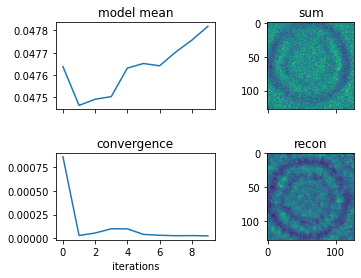

In [40]:
fig = emc2d.viz.show_emc_state(emc)

mse = 36.382


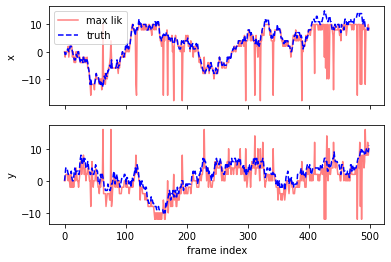

In [41]:
recon_drifts, recon_model = emc.centre_by_first_frame()
mse = emc2d.sim.mse_error(recon_drifts, true_traj=traj)
fig2 = emc2d.viz.show_maximum_likelihood_drifts(emc, true_traj=traj)

print(f"mse = {mse}")

In [42]:
pmat = emc.folded_membership_probability

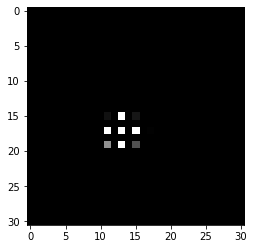

In [43]:
plt.imshow(pmat[1], vmin=0, vmax=0.01, cmap='gray')

## Select subregions for each frame

In [44]:
def select_frame_subregions(folded_membership_probability, 
                            drift_radius: Tuple[int, int], 
                            drifts_in_use: List[int], 
                            r: int, 
                            threshold: float = 1e-3):
    
    h, w = 2 * drift_radius[0] + 1, 2 * drift_radius[1] + 1
    n_frames = folded_membership_probability.shape[0]
    binary = folded_membership_probability < threshold
    bmap = np.array([distance_transform_edt(binary[k]) <= r for k in range(n_frames)])
    bmap_r = bmap.reshape(n_frames, -1)
    return [np.argwhere(b).squeeze() for b in bmap_r]

In [45]:
frame_drifts_in_use = select_frame_subregions(
    emc.folded_membership_probability, emc.drift_radius, emc.drifts_in_use, r=3, threshold=1e-2)

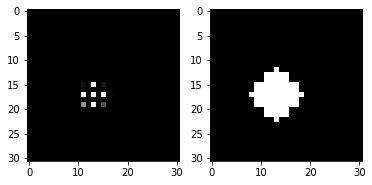

In [46]:
idx = 1
bmap = np.zeros(shape=(n_drifts))
bmap[frame_drifts_in_use[idx]] = 1

_, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(pmat[idx], vmin=0, vmax=0.01, cmap='gray')
ax2.imshow(bmap.reshape((2*drift_radius[0] + 1), -1), cmap="gray");

(225, 500)

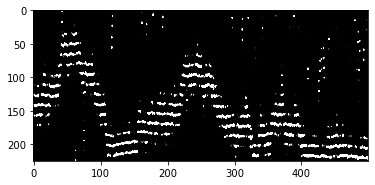

In [47]:
plt.imshow(emc.membership_probability, vmin=0, vmax=0.01, cmap='gray')
emc.membership_probability.shape

In [48]:
emc.run_frame_sparse(iterations=10, frame_drifts_in_use=frame_drifts_in_use, lpfs=1.5)

100%|██████████| 10/10 [00:03<00:00,  3.27it/s]                                                                        


(961, 500)

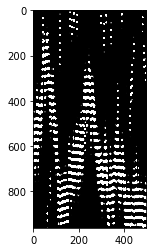

In [49]:
plt.imshow(emc.membership_probability, vmin=0, vmax=0.0001, cmap='gray')
emc.membership_probability.shape

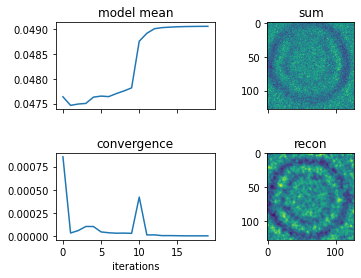

In [50]:
fig = emc2d.viz.show_emc_state(emc)

mse = 34.624


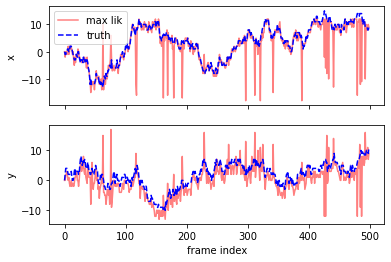

In [51]:
recon_drifts, recon_model = emc.centre_by_first_frame()
mse = emc2d.sim.mse_error(recon_drifts, true_traj=traj)
fig2 = emc2d.viz.show_maximum_likelihood_drifts(emc, true_traj=traj)

print(f"mse = {mse}")

In [27]:
pmat2 = emc.folded_membership_probability

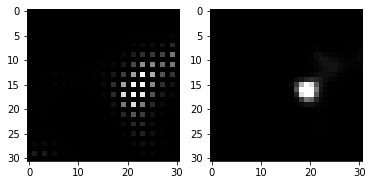

In [28]:
k = 495
_, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow( pmat[k],  cmap='gray', vmin=0, vmax=0.05)
ax2.imshow(pmat2[k], cmap='gray', vmin=0, vmax=0.05)

In [29]:
xs, ys = emc.maximum_likelihood_drifts().T

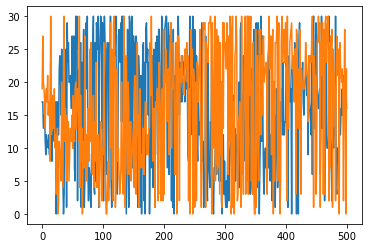

In [30]:
plt.plot(xs)
plt.plot(ys)

12.097714883513728

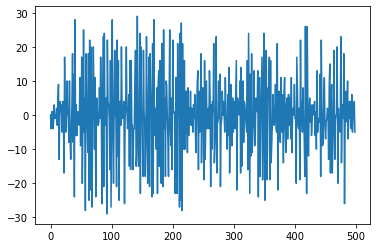

In [31]:
plt.plot(np.diff(xs))
np.diff(xs).std()

In [32]:
condx = np.abs(np.diff(xs)) < np.diff(xs).std()
condy = np.abs(np.diff(ys)) < np.diff(ys).std()
idx = np.argwhere(condx & condy)

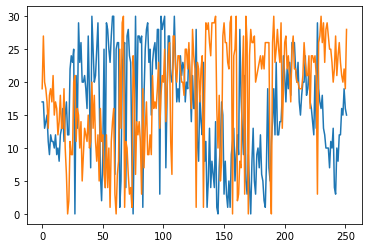

In [33]:
xss = xs[idx].squeeze()
yss = ys[idx].squeeze()
plt.plot(xss)
plt.plot(yss)